In [73]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
import random

import torch 
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn 
from torch import optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F

from joblib import Parallel, delayed
from Evolution.EvolutionaryLib import BaseChromosome, ChromosomeClassFactory


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

<h1> Data preparation </h1>

In [74]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item][0], self.data[item][1]

classes = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
train_size = 3000
test_size = 150 
train_batch_size = 48
test_batch_size = 32

In [75]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(24)
])

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transformer,
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transformer
)

train_indices = torch.cat([torch.where(train_data.targets == c)[0][:train_size] for c in classes])
test_indices = torch.cat([torch.where(test_data.targets == c)[0][:test_size] for c in classes])

train_data = torch.utils.data.Subset(train_data, train_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

train_dataset = MyDataset(train_data)
test_dataset = MyDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

<h1> Network template </h1>

In [76]:
class CNN(nn.Module): 
    def __init__(self, kernel_structure: tuple[int], classifier_structure: tuple[int], n_channels: int, out_classes: int): 
        super(CNN, self).__init__()
        self.image_size = (24, 24)
        self.kernel_structure = kernel_structure
        self.classifier_structure = classifier_structure
        cropped_img = (self.image_size[0] - sum(kernel_structure) + len(kernel_structure), 
                       self.image_size[1]  - sum(kernel_structure) + len(kernel_structure))
        self.cropped_img = cropped_img
        self.channels = n_channels

        # Convolutional part initialisation 
        architecture = [nn.Conv2d(in_channels=1, out_channels=self.channels, kernel_size=kernel_structure[0]), nn.ReLU()]
        for kernel_size in kernel_structure[1:]: 
            architecture.append(nn.Conv2d(in_channels=self.channels, out_channels=self.channels, kernel_size=kernel_size))
            architecture.append(nn.ReLU())

        self.convolve = nn.Sequential(
            *architecture
        )

        # CLassifier part initialisation 
        architecture = [nn.Linear(self.channels * cropped_img[0] * cropped_img[1], classifier_structure[0]), nn.ReLU()]
        for i in range(len(classifier_structure) - 1): 
            architecture.append(nn.Linear(classifier_structure[i], classifier_structure[i+1]))    
            architecture.append(nn.ReLU())

        architecture.append(nn.Linear(classifier_structure[-1], out_classes))

        self.classifier = nn.Sequential(
            *architecture
        )

    def forward(self, x):
        x = self.convolve(x)
        x = self.classifier(x.view(-1, self.channels * self.cropped_img[0] * self.cropped_img[1]))
        return F.log_softmax(x, dim=1)
criterion = nn.CrossEntropyLoss()

In [77]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    for _ in range(epoch): 
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
    
            output = model(data).softmax(dim=1)
    
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()

def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return 100. * correct / len(test_loader.dataset) 

<h1> Chromosome template and structure </h1>

In [78]:
class MyChromosome(BaseChromosome):
    def __init__(self):
        super().__init__()

    def crossover(self, other):
        new = MyChromosome()
        self.copy(new)

        new['kernel_structure'] = self._kernel_structure.crossover(other._kernel_structure)
        new['classifier_structure'] = self._classifier_structure.crossover(other._classifier_structure)

        new['lr'] = (self['lr'] + other['lr']) / 2
        new['epochs'] = random.choice([self['epochs'], other['epochs']])
        new['channels'] = random.choice([self['channels'], other['channels']])

        return new

    def mutate(self, rate=0.3):
        new = MyChromosome()
        self.copy(new)

        if random.random() < rate:
            new.kernel_structure = new._kernel_structure.mutate()
        else:
            new.kernel_structure = self.kernel_structure

        if random.random() < rate:
            new.classifier_structure = new._classifier_structure.mutate()
        else:
            new.classifier_structure = self.classifier_structure

        
        new.channels = new._channels.get() if random.random() < rate else self.channels
        new.epochs = new._epochs.get() if random.random() < rate else self.epochs
        new.lr = new._lr.get() if random.random() < rate else self.lr
        
        return new

chromosome_factory = ChromosomeClassFactory(
        kernel_structure={'n':[2, 3, 4], 'range': [3, 5]}, 
        classifier_structure={'n': [1, 2, 3, 4], 'range': list(range(25, 75))}, 
        channels = list(range(1, 11)), 
        lr=(1e-7, 1), 
        epochs=list(range(2, 15))
)

In [79]:
import torch.optim as optim
from math import log

def evaluate(chromosome, show_metric=False): 
    n_iterations = 3
    metric = 0

    for _ in range(n_iterations): 
        model = CNN(chromosome.kernel_structure, chromosome.classifier_structure, chromosome.channels, len(classes)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=chromosome.lr)
        
        train(model, device, train_loader, optimizer, chromosome.epochs)
        metric += test(model, device, test_loader)
        
    metric /= n_iterations
    
    if show_metric: 
        print(f'{metric=}')
        
    return metric

<h1> Evolutionary algorithm </h1>

In [80]:
# evolution hyperparameters initialisation 
POPULATION_SIZE = 30
ITERATIONS = 40
best = None

In [81]:
statistic_best = []
statistic_mean = []

statistic_n_epochs = []
statistic_lr = []

statistic_kernel_size = []
statistic_n_kernel_layers = []
statistic_n_channels = [] 

statistic_n_neurons = []
statistic_n_layers = []


population = []
for _ in range(POPULATION_SIZE):
    c = chromosome_factory.generate(MyChromosome)
    population.append(c)

with Parallel(n_jobs=4) as parallel: 
    for iteration in tqdm(range(ITERATIONS)):
        # scores = [evaluate(chromosome) for chromosome in population]
        scores = parallel(delayed(evaluate)(chromosome) for chromosome in population)
        for i, chromosome in enumerate(population):
            chromosome.set_score(scores[i])
    
    
        # selection of best instances 
        population = sorted(population, key=lambda x: x.get_score(), reverse=True)[:POPULATION_SIZE // 3]
        # check for the best solution 
        if best is None or population[0].get_score() > best.get_score():
            best = population[0]

        statistic_best.append(best.get_score())
        statistic_mean.append(sum(map(MyChromosome.get_score, population))/POPULATION_SIZE)
        
        statistic_n_epochs.append(best.epochs)
        statistic_lr.append(best.lr)
        
        statistic_kernel_size.append(sum(best.kernel_structure)/len(best.kernel_structure))
        statistic_n_kernel_layers.append(len(best.kernel_structure))
        statistic_n_channels.append(best.channels)

        statistic_n_neurons.append(sum(best.classifier_structure))
        statistic_n_layers.append(len(best.classifier_structure))
        
    
        # filling the population with new genes 
        while len(population) < POPULATION_SIZE:
            r = random.random()
            if r < 0.33:
                population.append(random.choice(population).crossover(random.choice(population)))
            elif 0.33 <= r < 0.66:
                population.append(random.choice(population).mutate())
            else:
                population.append(chromosome_factory.generate(MyChromosome))
    else: 
        # scores = [evaluate(chromosome) for chromosome in population]
        scores = parallel(delayed(evaluate)(chromosome) for chromosome in population)
        for i, chromosome in enumerate(population):
            chromosome.set_score(scores[i])

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████| 40/40 [19:17:38<00:00, 1736.46s/it]


In [96]:
print(best)

--Chromosome--
score: 97.15555555555555
kernel_structure: (5, 5)
classifier_structure: (70,)
channels: 8
lr: 0.0014007131074799356
epochs: 11



In [122]:
import pickle 


for i, ch in enumerate(population): 
    ps = pickle.dumps(ch)

    with open(f'chromosomes/channels_{i}.txt', mode='wb') as file: 
        ps = pickle.dumps(ch)
        file.write(ps)

# for i in range(30): 
#     ch_loaded = pickle.loads(open(f'chromosomes/{i}.txt', mode='rb').read())
#     print(ch_loaded)

<h1> Statistic </h1>

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
best_population = list(filter(lambda x: x.get_score() > 80, sorted(population, key=MyChromosome.get_score, reverse=True)))

for chromosome in best_population: 
    print(chromosome)

--Chromosome--
score: 97.44444444444444
kernel_structure: (5, 5)
classifier_structure: (70,)
channels: 8
lr: 0.0014007131074799356
epochs: 11

--Chromosome--
score: 97.42222222222222
kernel_structure: (5, 5)
classifier_structure: (70,)
channels: 8
lr: 0.0014007131074799356
epochs: 11

--Chromosome--
score: 97.22222222222221
kernel_structure: (5, 5)
classifier_structure: (70,)
channels: 8
lr: 0.0014007131074799356
epochs: 11

--Chromosome--
score: 97.17777777777776
kernel_structure: (5, 5)
classifier_structure: (63,)
channels: 8
lr: 0.0014007131074799356
epochs: 11

--Chromosome--
score: 97.15555555555555
kernel_structure: (5, 5)
classifier_structure: (70,)
channels: 8
lr: 0.0014007131074799356
epochs: 11

--Chromosome--
score: 97.11111111111113
kernel_structure: (5, 5)
classifier_structure: (63,)
channels: 8
lr: 0.0014007131074799356
epochs: 11

--Chromosome--
score: 97.11111111111113
kernel_structure: (5, 5)
classifier_structure: (30,)
channels: 9
lr: 0.0014007131074799356
epochs: 11


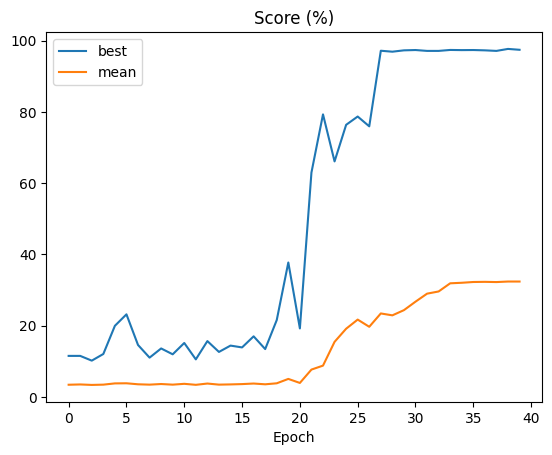

In [135]:
plt.title("Score (%)")
plt.xlabel("Epoch")
plt.plot(statistic_best, label='best')
plt.plot(statistic_mean, label='mean')
plt.legend()
plt.show()

<Axes: title={'center': 'Last generation score (best part)'}, xlabel='Score (%)', ylabel='Count'>

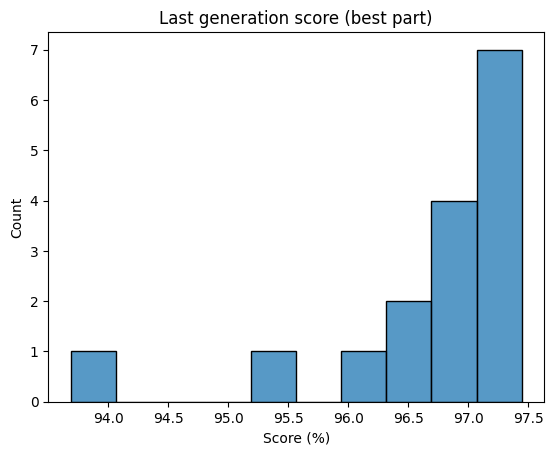

In [134]:
plt.title("Last generation score (best part)")
plt.xlabel("Score (%)")
sns.histplot(list(map(MyChromosome.get_score, best_population)))

<h2> Evolutionary algorithm statistic</h2>

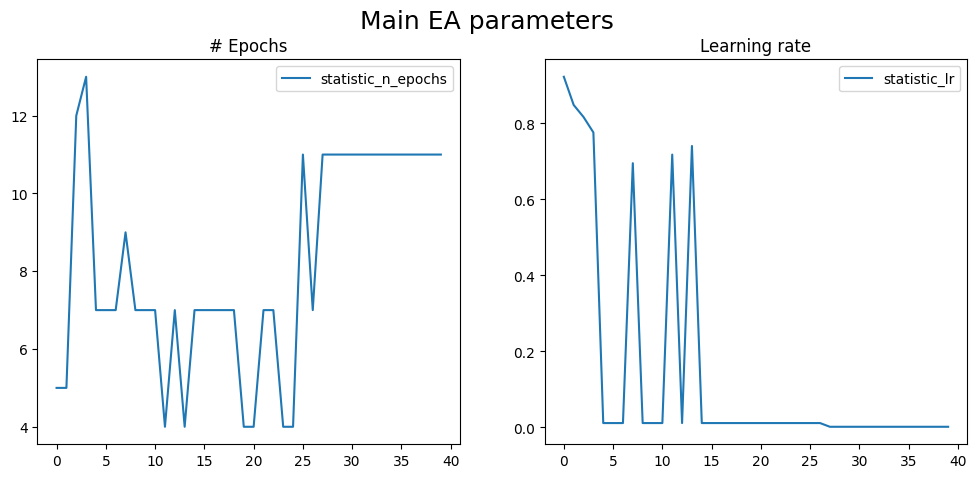

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle("Main EA parameters", fontsize=18)

axes[0].set_title('# Epochs')
axes[0].plot(statistic_n_epochs, label='statistic_n_epochs')
axes[0].legend()

axes[1].set_title('Learning rate')
axes[1].plot(statistic_lr, label='statistic_lr')
axes[1].legend()

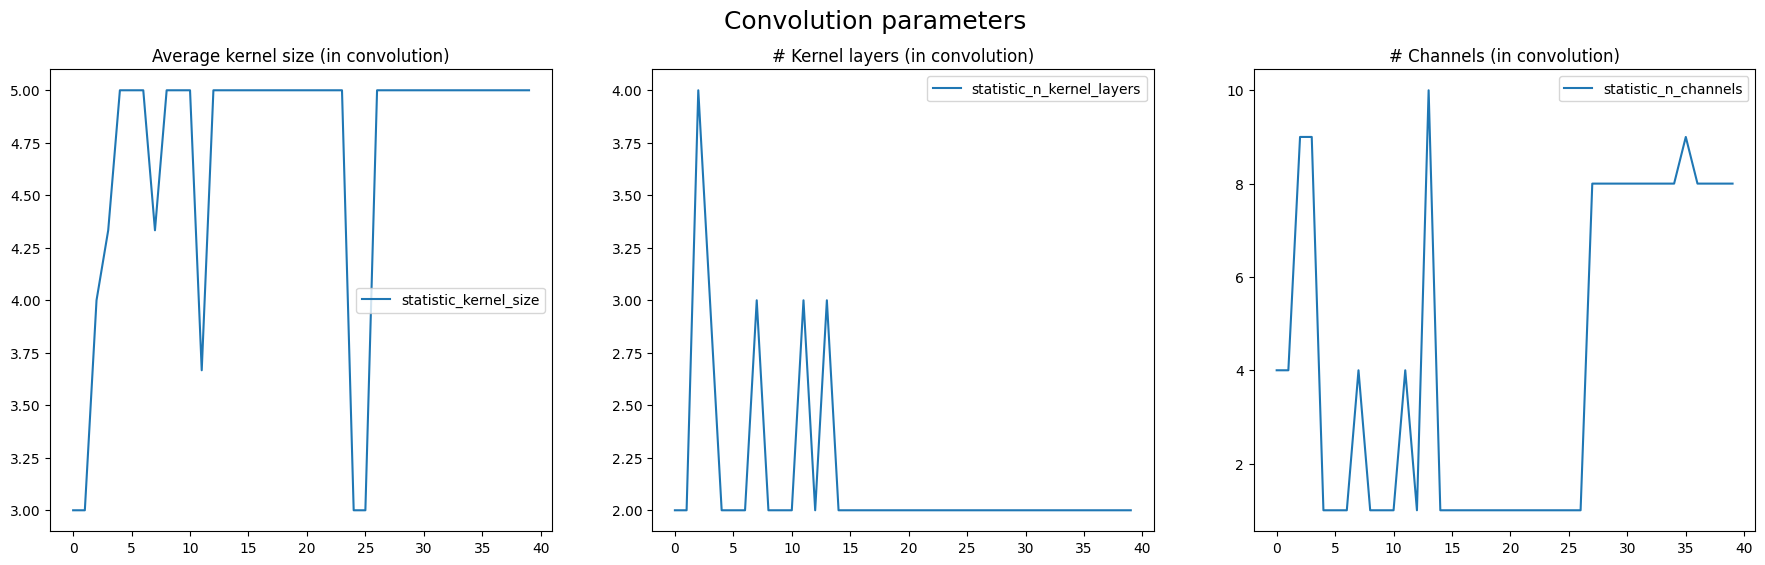

In [174]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

fig.suptitle("Convolution parameters", fontsize=18)

axes[0].set_title('Average kernel size (in convolution)')
axes[0].plot(statistic_kernel_size, label='statistic_kernel_size')
axes[0].legend()

axes[1].set_title('# Kernel layers (in convolution)')
axes[1].plot(statistic_n_kernel_layers, label='statistic_n_kernel_layers')
axes[1].legend()

axes[2].set_title('# Channels (in convolution)')
axes[2].plot(statistic_n_channels, label='statistic_n_channels')
axes[2].legend()

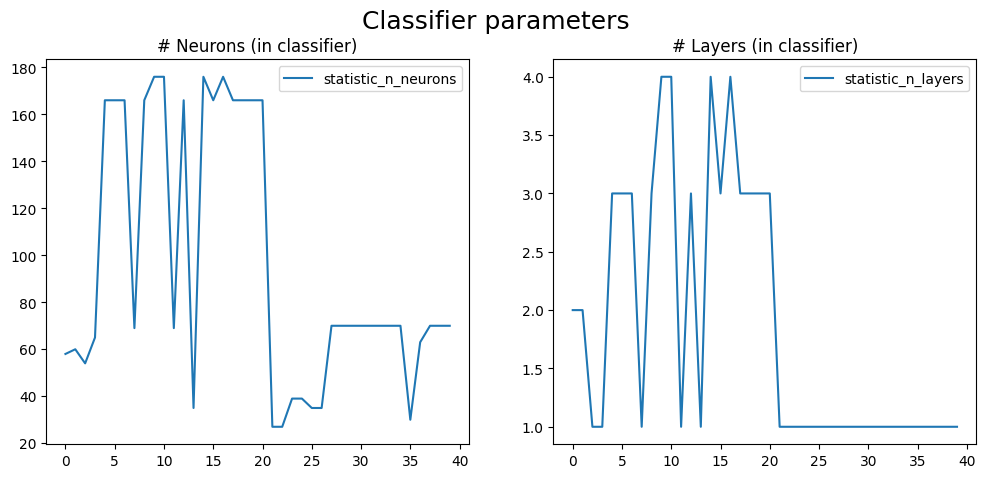

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle("Classifier parameters", fontsize=18)

axes[0].set_title('# Neurons (in classifier)')
axes[0].plot(statistic_n_neurons, label='statistic_n_neurons')
axes[0].legend()

axes[1].set_title('# Layers (in classifier)')
axes[1].plot(statistic_n_layers, label='statistic_n_layers')
axes[1].legend()